In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [127]:
data = pd.read_csv('C:/Users/ASUS/Desktop/NFSML/NVDA7.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-23,55.107498,56.047501,54.177502,55.264999,54.819244,62643600
1,2018-10-24,54.877499,55.347500,49.712502,49.852501,49.450401,88428800
2,2018-10-25,48.867500,52.437500,48.419998,51.959999,51.540897,95172000
3,2018-10-26,49.577499,51.209999,48.279999,49.572498,49.172657,66478400
4,2018-10-29,50.997501,51.032501,44.002499,46.404999,46.030693,75801600


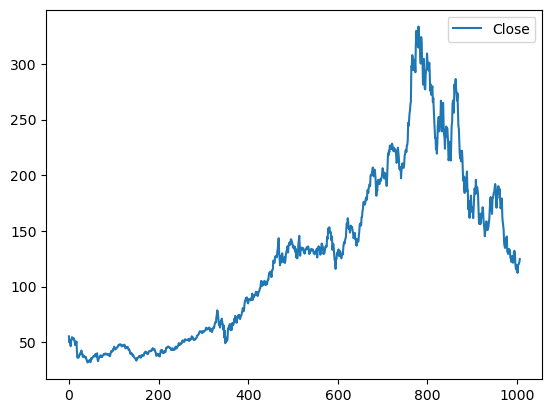

In [128]:
close = data[['Close']]
close.plot()

In [129]:
ds = close.values

In [130]:
# Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))
len(ds_scaled), len(ds)

(1007, 1007)

In [131]:
# Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size
train_size, test_size

(704, 303)

In [132]:
# Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [133]:
# creating dataset in time series for LSTM model 
# X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [134]:
#Taking 15 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [135]:
X_train.shape,y_train.shape

((603, 100), (603,))

In [136]:
X_test.shape, y_test.shape

((202, 100), (202,))

In [137]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [138]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [139]:
# Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
10/10 [==============================] - 8s 267ms/step - loss: 0.0222 - val_loss: 0.0095
Epoch 2/100
10/10 [==============================] - 1s 112ms/step - loss: 0.0042 - val_loss: 0.0088
Epoch 3/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 4/100
10/10 [==============================] - 1s 113ms/step - loss: 7.7754e-04 - val_loss: 0.0078
Epoch 5/100
10/10 [==============================] - 1s 114ms/step - loss: 5.9092e-04 - val_loss: 0.0070
Epoch 6/100
10/10 [==============================] - 1s 113ms/step - loss: 6.2027e-04 - val_loss: 0.0062
Epoch 7/100
10/10 [==============================] - 1s 116ms/step - loss: 5.5936e-04 - val_loss: 0.0069
Epoch 8/100
10/10 [==============================] - 1s 114ms/step - loss: 5.5602e-04 - val_loss: 0.0066
Epoch 9/100
10/10 [==============================] - 1s 116ms/step - loss: 5.6908e-04 - val_loss: 0.0082
Epoch 10/100
10/10 [==============================] - 1s 116ms/step

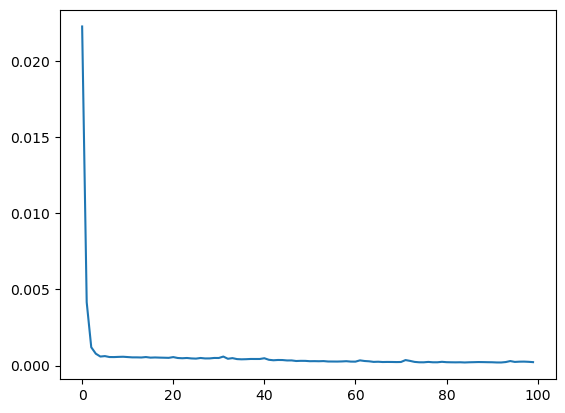

In [140]:
# Plotting loss
loss = model.history.history['loss']
plt.plot(loss)

In [141]:
# Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

7/7 [==============================] - 0s 28ms/step


In [142]:
# Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

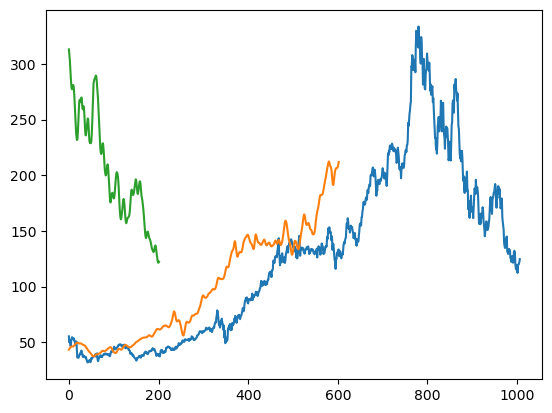

In [143]:
# Visualisation
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [144]:
type(train_predict)

numpy.ndarray

In [145]:
test = np.vstack((train_predict,test_predict))

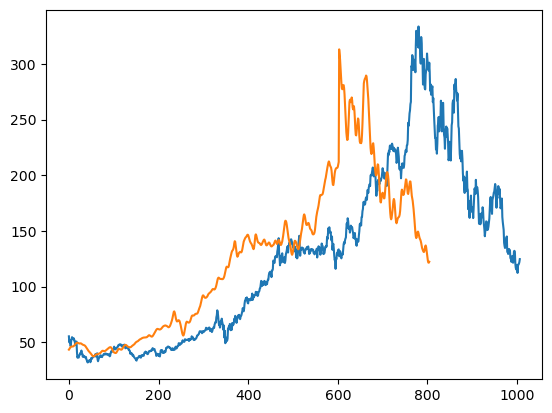

In [146]:
# Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [147]:
len(ds_test)

303

In [148]:
# Getting the last 100 days records
fut_inp = ds_test[203:]
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)
fut_inp.shape

(1, 100)

In [149]:
# Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [150]:
# Predicting next 15 days price suing the current data
# It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<14):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.3129107654094696], [0.3213179111480713], [0.3301587402820587], [0.33915621042251587], [0.3481656312942505], [0.3570995330810547], [0.3658909201622009], [0.3744814395904541], [0.38282203674316406], [0.39087626338005066], [0.39862263202667236], [0.4060565233230591], [0.41318807005882263], [0.42004111409187317]]


In [151]:
len(ds_scaled)

1007

In [152]:
# Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,115)

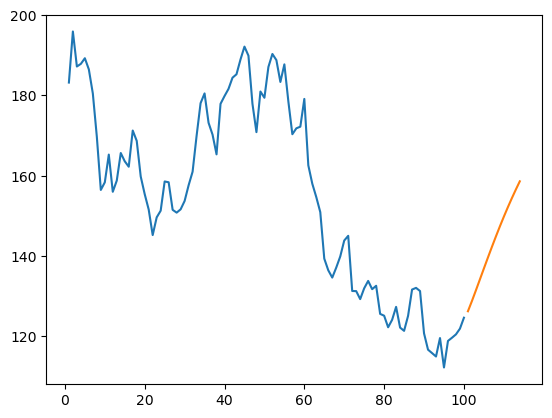

In [153]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[907:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [154]:
ds_new = ds_scaled.tolist()
len(ds_new)

1007

[0.3321964060996587]

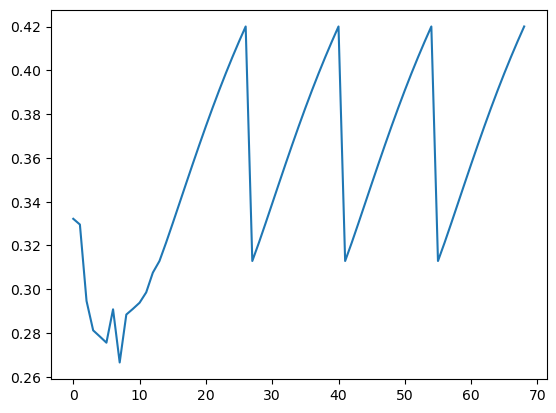

In [168]:
# Extend helps fill the missing values with approximate values
ds_new.extend(lst_output)
plt.plot(ds_new[994:])

In [174]:
# Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

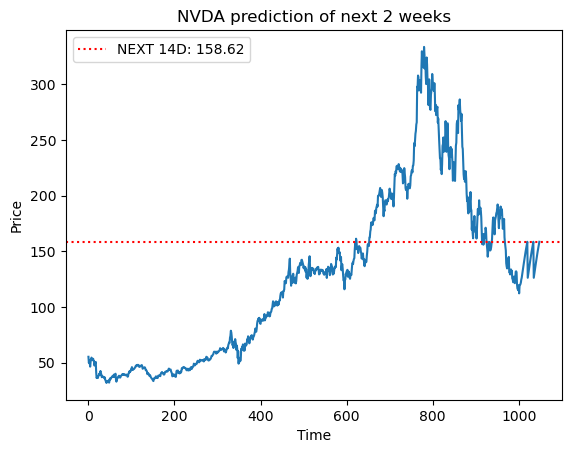

In [166]:
#Plotting final results with predicted value after 14 Days
plt.plot(final_graph)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next 2 weeks".format("NVDA"))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 14D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [179]:
LSTM_model_new_index=[]
LSTM_model_new_prediction=[]

for i in range(1,15):
    LSTM_model_new_index.append(i-1)
    LSTM_model_new_prediction.append(final_graph[-(15-i)][0])
    
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions = pd.DataFrame(zip(LSTM_model_new_index,LSTM_model_new_prediction), 
                                 columns=["index","Close"])
model_predictions

,index,Close
0,0,126.265925
1,1,128.804799
2,2,131.474641
3,3,134.191787
4,4,136.912542
5,5,139.610492
6,6,142.265403
7,7,144.859654
8,8,147.378431
9,9,149.810727


In [181]:
model_predictions.to_csv("C:/Users/ASUS/Desktop/NFSML/Shen_Licong_Impl_1.csv", index=False)